## Dynamic Asteroseismology
### Signal removal

This notebook demonstrates the an example of quick and easy signal removal to search for periodicity underneath a stronger binary signal.

For this notebook, you'll need to download: [tic049677785_lc.dat](https://iacerasmus.github.io/ERASMUS2022/data/tic049677785_lc.dat)

However, there are a number of other TESS lightcurves for you to try:\
[tic0142874476_lc.dat](https://iacerasmus.github.io/ERASMUS2022/data/tic0142874476_lc.dat) \
[tic0190693377_lc.dat](https://iacerasmus.github.io/ERASMUS2022/data/tic0190693377_lc.dat) \
[tic0229585356_lc.dat](https://iacerasmus.github.io/ERASMUS2022/data/tic0229585356_lc.dat) \
[tic0321947833_lc.dat](https://iacerasmus.github.io/ERASMUS2022/data/tic0321947833_lc.dat) \
[tic0418292123_lc.dat](https://iacerasmus.github.io/ERASMUS2022/data/tic0418292123_lc.dat) \
[tic048084398_lc.dat](https://iacerasmus.github.io/ERASMUS2022/data/tic048084398_lc.dat) \
[tic091369561_lc.dat](https://iacerasmus.github.io/ERASMUS2022/data/tic091369561_lc.dat) \
[tic097467902_lc.dat](https://iacerasmus.github.io/ERASMUS2022/data/tic097467902_lc.dat) \
[tic129764561_lc.dat](https://iacerasmus.github.io/ERASMUS2022/data/tic129764561_lc.dat) \
[tic152223725_lc.dat](https://iacerasmus.github.io/ERASMUS2022/data/tic152223725_lc.dat) \
[tic219238495_lc.dat](https://iacerasmus.github.io/ERASMUS2022/data/tic219238495_lc.dat) \
[tic231860752_lc.dat](https://iacerasmus.github.io/ERASMUS2022/data/tic231860752_lc.dat)


**WARNING: Some lightcurves are in magnitude, others are in normalized flux -- don't blame me, blame past Cole**

In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

from pythia.utils.resampling import run_binning, run_mean_smooth
from pythia.utils.conversions import time_to_ph
from pythia.timeseries.periodograms import LS_periodogram
from pythia.effective_models.binary import get_interp_model


plt.rcParams.update({
    "text.usetex": True,
        "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams.update({
    "pgf.rcfonts": False,
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
         r"\usepackage{amsmath}",
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage{cmbright}",
    ]),
})

plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

In [50]:
# times, signal = np.loadtxt('tic049677785_lc.dat').T
times, signal = np.loadtxt('tic091369561_lc.dat').T

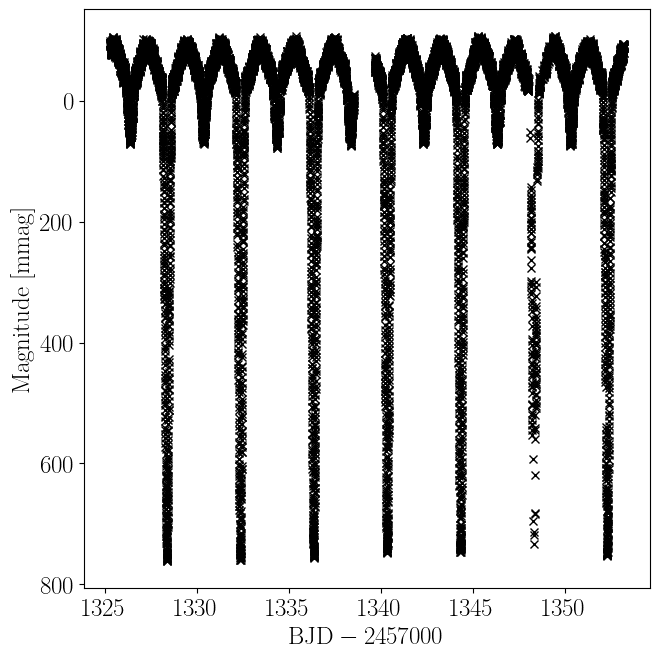

In [52]:
fig, ax = plt.subplots(1,1,figsize=(6.6957, 6.6957), num=1)
ax.plot(times, signal*1e3, 'kx')
ax.set_xlabel(r'${\rm BJD-2457000}$',fontsize=18)
ax.set_ylabel(r'${\rm Magnitude~[mmag]}$',fontsize=18)
ax.set_ylim(ax.get_ylim()[::-1])
fig.tight_layout()

In [53]:
nu, amp = LS_periodogram(times, signal-np.mean(signal))
forb = nu[np.argmax(amp[nu<10.])]
Aorb = amp[np.argmax(amp[nu<10.])]

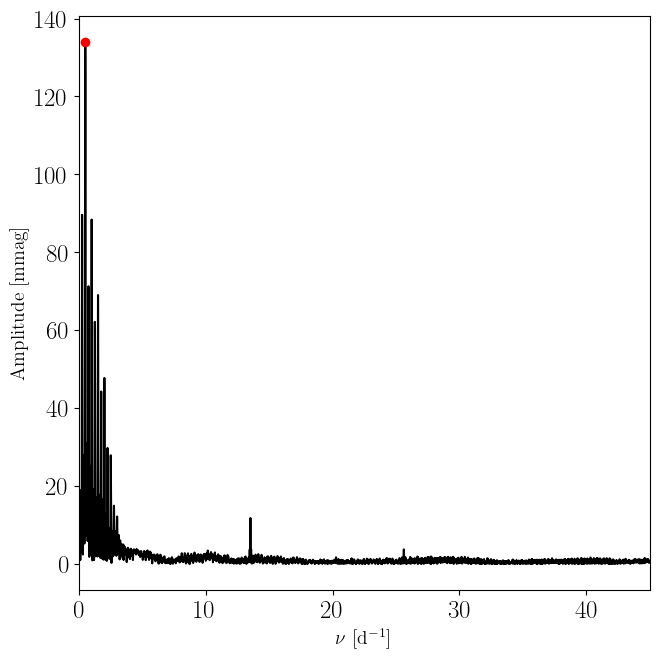

In [54]:
fig,ax = plt.subplots(1,1,figsize=(6.6957,6.6957),num=2)
ax.plot(nu,amp*1e3,'k-')
ax.plot(forb, Aorb*1e3, 'ro')
ax.set_xlabel(r'$\nu\,\,{\rm [d^{-1}]}$',fontsize=14)
ax.set_ylabel(r'${\rm Amplitude\,\,[mmag]}$',fontsize=14)
ax.set_xlim(0.,45)
fig.tight_layout()

In [55]:
%matplotlib inline
import ipywidgets as wdg  
from ipywidgets import interact

def plot_folded_lc(period, t0, nbins):
    
#     fig, ax = plt.subplots(1,1,figsize=(6.6957,6.6957), num=3)
    fig = plt.figure(constrained_layout=True, figsize=(6.6957*1.5,6.6957), num=4)
    axes = fig.subplot_mosaic(
    """
    AAA...
    AAACCC
    BBBCCC
    """)
    ph = time_to_ph(times, period, t0)
    bx, by, _ = run_binning(ph, signal, yerr=None, phStart=0., phStop=1., nbins=nbins)
    axes['A'].plot(ph, signal, 'k.')
    axes['A'].plot(ph+1, signal, 'k.')
    axes['A'].plot(bx, by, 'ro')
    axes['A'].plot(bx+1, by, 'ro')
    axes['A'].set_ylabel(r'${\rm Magnitude~[mmag]}$',fontsize=18)
    axes['A'].set_ylim(axes['A'].get_ylim()[::-1])

    
    ph_, x_, y_, ifunc = get_interp_model(times, signal, period, t0,
                                         phase_knots=[[0,1]], nbins=[nbins]
                                        )
    residuals = signal - ifunc(ph)
    axes['B'].plot(ph, residuals, 'k.')
    axes['B'].plot(ph+1, residuals, 'k.')
    axes['B'].set_ylabel(r'${\rm Residuals~[mmag]}$',fontsize=18)
    axes['B'].set_xlabel(r'${\rm Phase}$',fontsize=18)
    axes['B'].set_ylim(axes['B'].get_ylim()[::-1])

    idx = np.isfinite(residuals)
    nu_r, amp_r = LS_periodogram(times[idx], residuals[idx])
        
    axes['C'].plot(nu_r, amp_r*1e3)
    axes['C'].set_xlabel(r'${\rm Frequency~[d^{-1}]}$',fontsize=14)
    axes['C'].set_ylabel(r'${\rm Amplitude~[mmag]}$',fontsize=14)
    axes['C'].set_xlim(0.,45)

    fig.canvas.draw_idle()
    

interact(plot_folded_lc, 
         period = wdg.FloatSlider(value=2./forb, description=r'$P_{\rm orb}$:',
            disabled=False, min=0, max=10., step=0.00001, readout_format='.6f'),
         t0 = wdg.FloatSlider( value=0., description='Reference Epoch:',
            disabled=False,min=-100, max=100., step=0.00001, readout_format='.6f') ,
         nbins = wdg.IntSlider(value=100, description='N bins: ', disabled=False, 
                               min=50, max=1000, step=5, readout_format='d')
        )

interactive(children=(FloatSlider(value=3.9828535070428503, description='$P_{\\rm orb}$:', max=10.0, readout_f…

<function __main__.plot_folded_lc(period, t0, nbins)>

## Now let's try it with a different rate of binning

Adopted bin-width:  0.02142857142857143
Adopted bin-width:  0.0034999999999999996
Adopted bin-width:  0.047142857142857146
Adopted bin-width:  0.0037500000000000007
Adopted bin-width:  0.027142857142857135
Adopted bin-width:  0.02142857142857143
Adopted bin-width:  0.0034999999999999996
Adopted bin-width:  0.047142857142857146
Adopted bin-width:  0.0037500000000000007
Adopted bin-width:  0.027142857142857135


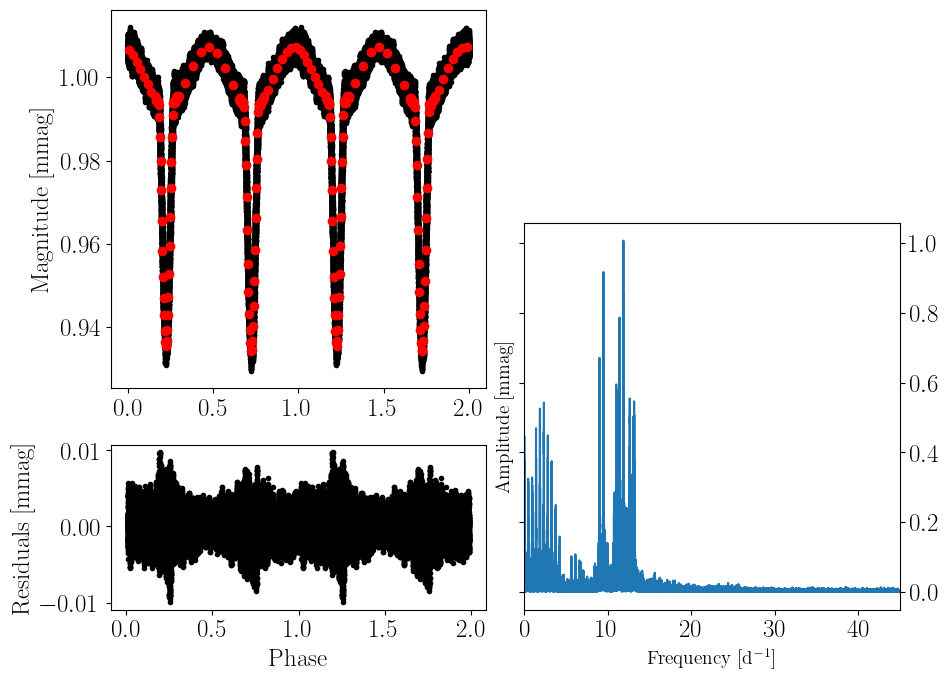

In [49]:
%matplotlib inline

period_ = 1.594270
period_ = 4.243430
t0_ = 0.

fig_ = plt.figure(constrained_layout=True, figsize=(6.6957*1.4,6.6957), num=5)
axes_ = fig_.subplot_mosaic(
"""
AAA...
AAACCC
BBBCCC
""")
phx = time_to_ph(times, period_, t0_)

phase_knots = [ [0.,0.15], [0.16, 0.3], [0.31, 0.64], [0.65,0.8], [0.81,1.] ]
nbins = [7,40,7,40,7]
bx, by = [],[]

for ii, knots in enumerate(phase_knots):
    bx_, by_, _ = run_binning(phx, signal, yerr=None, phStart=knots[0], phStop=knots[1], nbins=nbins[ii])
    bx.append(bx_)
    by.append(by_)

bx,by = np.hstack(bx), np.hstack(by)


axes_['A'].plot(phx, signal, 'k.')
axes_['A'].plot(phx+1, signal, 'k.')
axes_['A'].plot(bx, by, 'ro')
axes_['A'].plot(bx+1, by, 'ro')
axes_['A'].set_ylabel(r'${\rm Magnitude~[mmag]}$',fontsize=18)
# axes_['A'].set_ylim(axes_['A'].get_ylim()[::-1])


ph_, x_, y_, ifunc = get_interp_model(times, signal, period_, t0_,
                                     phase_knots=phase_knots, nbins=nbins
                                    )
residuals = signal - ifunc(phx)
axes_['B'].plot(phx, residuals, 'k.')
axes_['B'].plot(phx+1, residuals, 'k.')
axes_['B'].set_ylabel(r'${\rm Residuals~[mmag]}$',fontsize=18)
axes_['B'].set_xlabel(r'${\rm Phase}$',fontsize=18)
# axes_['B'].set_ylim(axes_['B'].get_ylim()[::-1])

idx = np.isfinite(residuals)
nu_r, amp_r = LS_periodogram(times[idx], residuals[idx])

axes_['C'].plot(nu_r, amp_r*1e3)
axes_['C'].set_xlabel(r'${\rm Frequency~[d^{-1}]}$',fontsize=14)
axes_['C'].set_ylabel(r'${\rm Amplitude~[mmag]}$',fontsize=14)
axes_['C'].set_xlim(0.,45)
axes_['C'].tick_params(axis='y', which='both', left=True, right=True, labelleft=False, labelright=True)





## The residuals

Now that we're confident that there's some signal left over, lets see what we can do with it!

In [8]:
# Thanks, Dan Hey!
from echelle import interact_echelle

/lhome/colej/software/miniconda3/envs/nominal3p9/lib/python3.9/site-packages/echelle-1.5.1-py3.9.egg/echelle/echelle.py:126: SyntaxWarning: "is" with a literal. Did you mean "=="?
/lhome/colej/software/miniconda3/envs/nominal3p9/lib/python3.9/site-packages/echelle-1.5.1-py3.9.egg/echelle/echelle.py:128: SyntaxWarning: "is" with a literal. Did you mean "=="?
/lhome/colej/software/miniconda3/envs/nominal3p9/lib/python3.9/site-packages/echelle-1.5.1-py3.9.egg/echelle/echelle.py:126: SyntaxWarning: "is" with a literal. Did you mean "=="?
/lhome/colej/software/miniconda3/envs/nominal3p9/lib/python3.9/site-packages/echelle-1.5.1-py3.9.egg/echelle/echelle.py:128: SyntaxWarning: "is" with a literal. Did you mean "=="?
/lhome/colej/software/miniconda3/envs/nominal3p9/lib/python3.9/site-packages/echelle-1.5.1-py3.9.egg/echelle/interact.py:88: SyntaxWarning: "is" with a literal. Did you mean "=="?
/lhome/colej/software/miniconda3/envs/nominal3p9/lib/python3.9/site-packages/echelle-1.5.1-py3.9.egg

In [9]:
interact_echelle(nu_r[nu<=45], amp_r[nu<=45], dnu_min=0.1, dnu_max=10.)